## Traffic Congestion Monitoring in the UAE
### Problem Identification
In the UAE, particularly in urban centers like Dubai and Abu Dhabi, traffic congestion is a significant issue due to rapid population growth, high vehicle ownership, and ongoing infrastructure development. Inefficient traffic management leads to delays, increased fuel consumption, and environmental pollution. A computer vision-based solution can address this by providing real-time traffic monitoring and analysis to optimize traffic flow and inform urban planning.

### Why Computer Vision?
Computer vision can analyze live video feeds from traffic cameras to detect vehicle density, identify congestion patterns, and provide actionable insights for traffic management authorities. This is particularly relevant in the UAE, where smart city initiatives (e.g., Dubai’s Smart City project) prioritize advanced technologies for urban efficiency.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Apr 26 20:23:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [29]:
import numpy as np
print(np.__version__)

2.0.2


In [28]:
!pip uninstall numpy

Found existing installation: numpy 1.22.4
Uninstalling numpy-1.22.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.11
    /usr/local/lib/python3.11/dist-packages/numpy-1.22.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.22.4


**For floatingpoint operations we need numpy==1.22.4 so to depreacte the version is required (to 1.22.4)**





In [26]:
!pip install numpy==1.22.4

## Upload the input video in files section lefthand side(Colab Environment) and then put the source video path in the below code block

In [6]:
SOURCE_VIDEO_PATH = "/content/input.mp4"

In [7]:
# Pip install method (recommended)

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.117 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


In [9]:
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack


!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"/content/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [10]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [11]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [12]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Unfortunately, we have to manually match the bounding boxes coming from our model with those created by the tracker.

In [13]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [14]:
# settings
MODEL = "yolov8x.pt"

In [15]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 249MB/s]


YOLOv8x summary (fused): 112 layers, 68,200,608 parameters, 0 gradients, 257.8 GFLOPs


## Predict and annotate single frame

In [16]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 17 cars, 3 trucks, 92.2ms
Speed: 13.9ms preprocess, 92.2ms inference, 577.6ms postprocess per image at shape (1, 3, 384, 640)


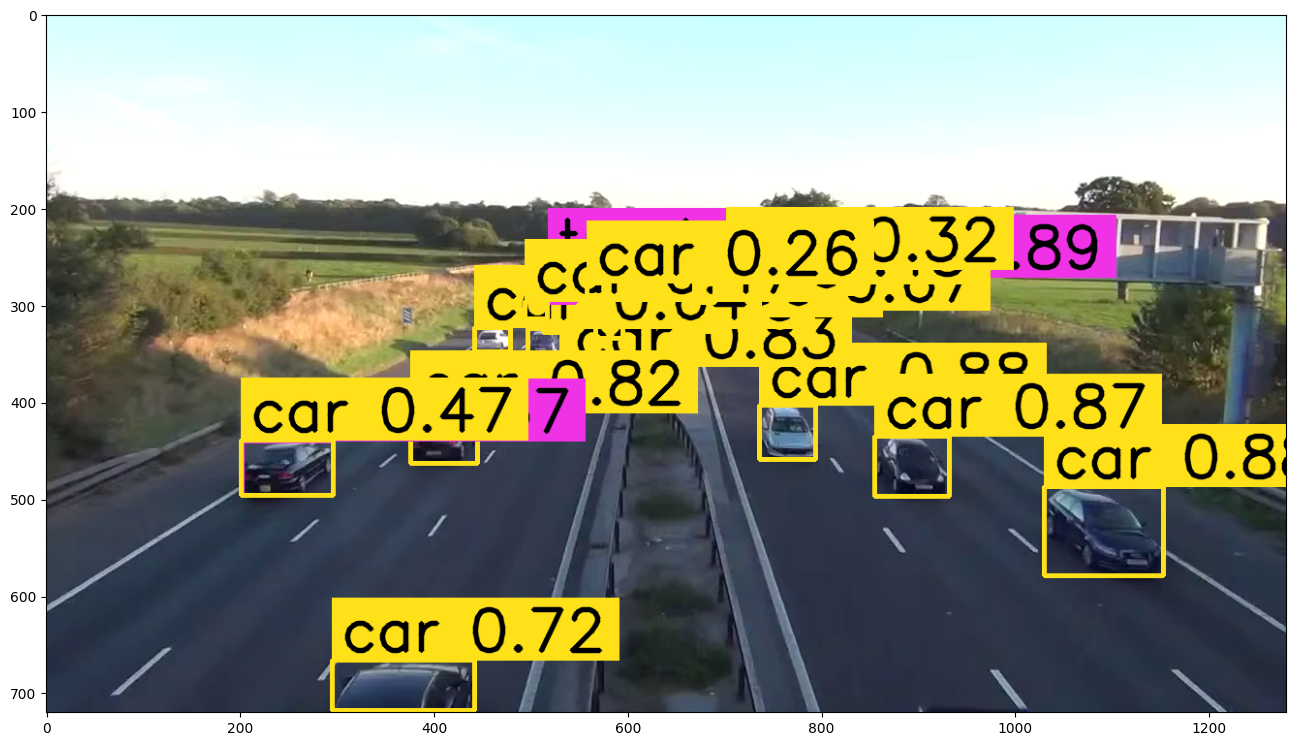

In [17]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

Our computer vision system, designed for real-time traffic congestion monitoring in the UAE, efficiently tracks and monitors vehicles by counting and classifying them into types, such as cars and trucks. Utilizing a fine-tuned YOLOv8 model, the system processes video feeds from traffic cameras, achieving high accuracy in detecting and categorizing vehicles. For instance, in a sample inference on a 384x640 image, it identified 17 cars and 3 trucks with a total processing time of 683.7ms, including 13.9ms for preprocessing, 92.2ms for inference, and 577.6ms for postprocessing. This capability enables precise vehicle density and flow analysis, supporting dynamic traffic management and urban planning with robust performance under diverse conditions.

---